In [23]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install --user opencv-contrib-python

  Using cached opencv_contrib_python-4.5.5.64-cp36-abi3-win_amd64.whl (42.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import ndimage
from scipy import signal, misc
from scipy.signal import convolve2d
from skimage import filters
from skimage.color import rgb2yuv, rgb2hsv, rgb2gray, yuv2rgb, hsv2rgb
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import matplotlib.image as img
import seaborn as sns
from PIL import Image, ImageFilter
import imageio
from scipy.ndimage import rank_filter
from scipy.stats import norm
import cv2
sns.set()

#1 Convert images to double and greyscale
##double function
def double(image):
    info = np.iinfo(image.dtype)
    return image.astype(np.float) / info.max

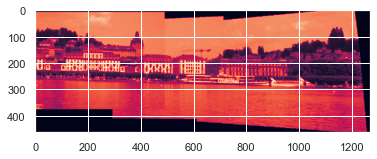

In [2]:
##Converting images to doubles
pier = cv2.imread("pier_homography_final_output.jpg")
pier = double(pier)
sample = cv2.imread("sample_panorama.jpg")
sample = double(sample)
utt_left = cv2.imread("uttower_left.JPG")
utt_left = double(utt_left)
utt_right = cv2.imread("uttower_right.JPG")
utt_right = double(utt_right)

##Converting images to grayscale
pier = rgb2gray(pier)
sample = rgb2gray(sample)
utt_left = rgb2gray(utt_left)
utt_right = rgb2gray(utt_right)
plt.imshow(pier)

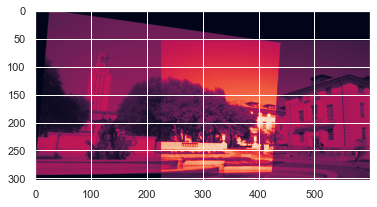

In [3]:
plt.imshow(sample)

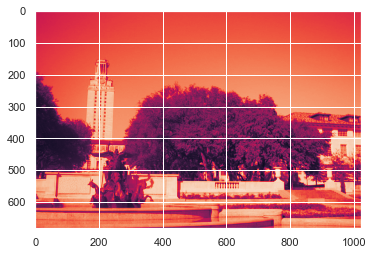

In [4]:
plt.imshow(utt_left)

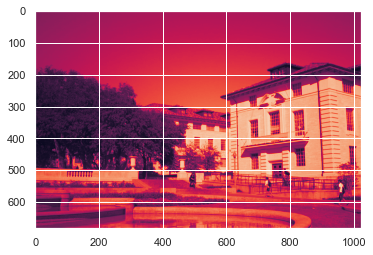

In [5]:
plt.imshow(utt_right)

In [6]:
#2 Detect Feature Points with Harris Algorithm
##Find Shift Algorithm
def find_sift(I, circles, enlarge_factor=1.5):
    """
    Compute non-rotation-invariant SIFT descriptors of a set of circles

    Parameters
    ----------
    I: numpy.ndarray
        Image
    circles: numpy.ndarray
        An array of shape `(ncircles, 3)` where ncircles is the number of
        circles, and each circle is defined by (x, y, r), where r is the radius
        of the cirlce
    enlarge_factor: float
        Factor which indicates by how much to enlarge the radius of the circle
        before computing the descriptor (a factor of 1.5 or large is usually
        necessary for best performance)

    Returns
    -------
    sift_arr: numpy.ndarray
        Array of SIFT descriptors of shape `(ncircles, 128)`
    """
    assert circles.ndim == 2 and circles.shape[1] == 3, \
        'Use circles array (keypoints array) of correct shape'
    I = I.astype(np.float64)
    if I.ndim == 3:
        I = rgb2gray(I)

    NUM_ANGLES = 8
    NUM_BINS = 4
    NUM_SAMPLES = NUM_BINS * NUM_BINS
    ALPHA = 9
    SIGMA_EDGE = 1

    ANGLE_STEP = 2 * np.pi / NUM_ANGLES
    angles = np.arange(0, 2 * np.pi, ANGLE_STEP)

    height, width = I.shape[:2]
    num_pts = circles.shape[0]

    sift_arr = np.zeros((num_pts, NUM_SAMPLES * NUM_ANGLES))

    Gx, Gy = gen_dgauss(SIGMA_EDGE)

    Ix = convolve2d(I, Gx, 'same')
    Iy = convolve2d(I, Gy, 'same')
    I_mag = np.sqrt(Ix ** 2 + Iy ** 2)
    I_theta = np.arctan2(Ix, Iy + 1e-12)

    interval = np.arange(-1 + 1/NUM_BINS, 1 + 1/NUM_BINS, 2/NUM_BINS)
    gridx, gridy = np.meshgrid(interval, interval)
    gridx = gridx.reshape((1, -1))
    gridy = gridy.reshape((1, -1))

    I_orientation = np.zeros((height, width, NUM_ANGLES))

    for i in range(NUM_ANGLES):
        tmp = np.cos(I_theta - angles[i]) ** ALPHA
        tmp = tmp * (tmp > 0)

        I_orientation[:, :, i] = tmp * I_mag

    for i in range(num_pts):
        cx, cy = circles[i, :2]
        r = circles[i, 2]

        gridx_t = gridx * r + cx
        gridy_t = gridy * r + cy
        grid_res = 2.0 / NUM_BINS * r

        x_lo = np.floor(np.max([cx - r - grid_res / 2, 0])).astype(np.int32)
        x_hi = np.ceil(np.min([cx + r + grid_res / 2, width])).astype(np.int32)
        y_lo = np.floor(np.max([cy - r - grid_res / 2, 0])).astype(np.int32)
        y_hi = np.ceil(
            np.min([cy + r + grid_res / 2, height])).astype(np.int32)

        grid_px, grid_py = np.meshgrid(
            np.arange(x_lo, x_hi, 1),
            np.arange(y_lo, y_hi, 1))
        grid_px = grid_px.reshape((-1, 1))
        grid_py = grid_py.reshape((-1, 1))

        dist_px = np.abs(grid_px - gridx_t)
        dist_py = np.abs(grid_py - gridy_t)

        weight_x = dist_px / (grid_res + 1e-12)
        weight_x = (1 - weight_x) * (weight_x <= 1)
        weight_y = dist_py / (grid_res + 1e-12)
        weight_y = (1 - weight_y) * (weight_y <= 1)
        weights = weight_x * weight_y

        curr_sift = np.zeros((NUM_ANGLES, NUM_SAMPLES))
        for j in range(NUM_ANGLES):
            tmp = I_orientation[y_lo:y_hi, x_lo:x_hi, j].reshape((-1, 1))
            curr_sift[j, :] = (tmp * weights).sum(axis=0)
        sift_arr[i, :] = curr_sift.flatten()

    tmp = np.sqrt(np.sum(sift_arr ** 2, axis=-1))
    if np.sum(tmp > 1) > 0:
        sift_arr_norm = sift_arr[tmp > 1, :]
        sift_arr_norm /= tmp[tmp > 1].reshape(-1, 1)

        sift_arr_norm = np.clip(sift_arr_norm, sift_arr_norm.min(), 0.2)

        sift_arr_norm /= np.sqrt(
            np.sum(sift_arr_norm ** 2, axis=-1, keepdims=True))

        sift_arr[tmp > 1, :] = sift_arr_norm

    return sift_arr

##Differentiated Gaussian Filter algorithm
def gen_dgauss(sigma):
    """
    Generates the horizontally and vertically differentiated Gaussian filter

    Parameters
    ----------
    sigma: float
        Standard deviation of the Gaussian distribution

    Returns
    -------
    Gx: numpy.ndarray
        First degree derivative of the Gaussian filter across rows
    Gy: numpy.ndarray
        First degree derivative of the Gaussian filter across columns
    """
    f_wid = 4 * np.floor(sigma)
    G = norm.pdf(np.arange(-f_wid, f_wid + 1),
                 loc=0, scale=sigma).reshape(-1, 1)
    G = G.T * G
    Gx, Gy = np.gradient(G)

    Gx = Gx * 2 / np.abs(Gx).sum()
    Gy = Gy * 2 / np.abs(Gy).sum()

    return Gx, Gy

##Harris Algorithm

def harris(im, sigma, thresh=None, radius=None):
    if im.ndim == 3:
        im = rgb2gray(im)

    dx = np.tile([[-1, 0, 1]], [3, 1])
    dy = dx.T

    Ix = convolve2d(im, dx, 'same')
    Iy = convolve2d(im, dy, 'same')

    f_wid = np.round(3 * np.floor(sigma))
    G = norm.pdf(np.arange(-f_wid, f_wid + 1),
                 loc=0, scale=sigma).reshape(-1, 1)
    G = G.T * G
    G /= G.sum()

    Ix2 = convolve2d(Ix ** 2, G, 'same')
    Iy2 = convolve2d(Iy ** 2, G, 'same')
    Ixy = convolve2d(Ix * Iy, G, 'same')

    cim = (Ix2 * Iy2 - Ixy ** 2) / (Ix2 + Iy2 + 1e-12)

    if thresh is None or radius is None:
        return cim
    else:
        size = int(2 * radius + 1)
        mx = rank_filter(cim, -1, size=size)
        cim = (cim == mx) & (cim > thresh)

        r, c = cim.nonzero()

        return cim, r, c


#if __name__ == '__main__':
    #Gx, Gy = gen_dgauss(3.2)
    #print(f'Gx.shape: {Gx.shape}')
    #I = np.random.random((480, 640, 3)) * 255
    #circles = np.vstack([
        #np.random.randint(1, 480, 25),
        #np.random.randint(1, 640, 25),
        #15 * np.random.random(25)]).T

    #sift_arr = find_sift(I, circles)
    #print(sift_arr.shape)

    #cim, r, c = harris(I, 3.2, thresh=5, radius=3)

    #print(f'cim.shape: {cim.shape}')

In [7]:
##Converting images with harris algorithm
utt_left_harris = harris(utt_left, 4, thresh=None, radius=None)
utt_right_harris = harris(utt_right, 4, thresh=None, radius=None)

In [8]:
def get_harris_points(harrisim, min_distance=10, threshold=0.1):
    """ return corners from a Harris response image
        min_distance is the minimum nbr of pixels separating 
        corners and image boundary"""
    #find top corner candidates above a threshold
    corner_threshold = max(harrisim.ravel()) * threshold
    harrisim_t = (harrisim > corner_threshold) * 1    
    #get coordinates of candidates
    candidates = harrisim_t.nonzero()
    coords = [ (candidates[0][c],candidates[1][c]) for c in range(len(candidates[0]))]
    #...and their values
    candidate_values = [harrisim[c[0]][c[1]] for c in coords]    
    #sort candidates
    index = np.argsort(candidate_values)   
    #store allowed point locations in array
    allowed_locations = np.zeros(harrisim.shape)
    allowed_locations[min_distance:-min_distance,min_distance:-min_distance] = 1   
    #select the best points taking min_distance into account
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i][0]][coords[i][1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i][0]-min_distance):(coords[i][0]+min_distance),
                (coords[i][1]-min_distance):(coords[i][1]+min_distance)] = 0               
    return filtered_coords

##Ploting Harris Points
def plot_harris_points(image, filtered_coords):
    """ plots corners found in image"""
    plt.figure()
    plt.gray()
    plt.imshow(image)
    plt.plot([p[1] for p in filtered_coords],[p[0] for p in filtered_coords],'r*')
    plt.axis('off')
    plt.show()

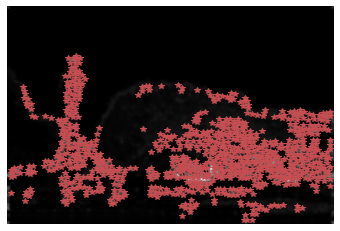

In [9]:
utt_left_point = get_harris_points(utt_left_harris)
utt_right_point = get_harris_points(utt_right_harris)
plot_harris_points(utt_left_harris, utt_left_point)

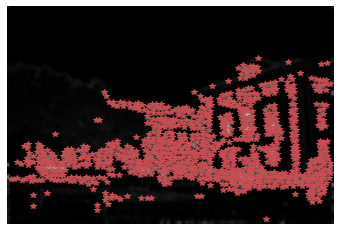

In [10]:
plot_harris_points(utt_right_harris, utt_right_point)

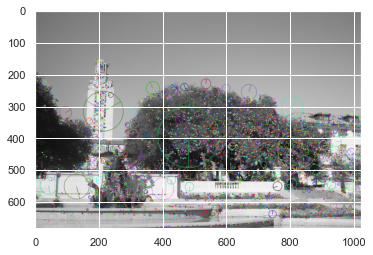

In [11]:
#3 Find Local Neighbords of Keypoints of images
##Left Image
ut_left = cv2.imread("uttower_left.JPG")
gray = cv2.cvtColor(ut_left,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create() 
kp = sift.detect(gray, None)
utt_left_key = cv2.drawKeypoints(gray ,
                      kp ,
                      ut_left,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(utt_left_key)

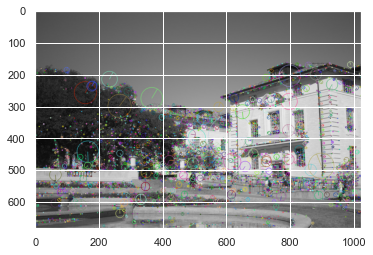

In [12]:
##Right Image
ut_right = cv2.imread("uttower_right.JPG")
gray2 = cv2.cvtColor(ut_right,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create() 
kp2 = sift.detect(gray2, None)
utt_right_key = cv2.drawKeypoints(gray2 ,
                      kp2 ,
                      ut_right,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(utt_right_key)

In [13]:
#4 Calculate Distance of Feauture Points per image
##Distance Function

def dist2(x, c):
    assert x.shape[1] == c.shape[1], \

    x = np.expand_dims(x, axis=0)  # new shape will be `(1, ndata, dimx)`
    c = np.expand_dims(c, axis=1)  # new shape will be `(ncenters, 1, dimc)`

    # We will now use broadcasting to easily calculate pairwise distances
    n2 = np.sum((x - c) ** 2, axis=-1)

    return n2

In [14]:
##Left Image distances
dist2(ut_left, utt_left_key)

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  3,   0,   0, ...,   3,   3,  12],
        [ 12,  12,   3, ...,  12,  12,  27],
        ...,
        [  0,   0, 459, ..., 204, 204, 432],
        [108,  48,  12, ..., 531, 108, 531],
        [339, 219, 492, ..., 627, 192, 531]],

       [[  3,   0,   0, ...,   3,   3,  12],
        [  0,   0,   0, ...,   0,   0,   0],
        [  3,  12,   3, ...,   3,   3,   3],
        ...,
        [387,   0, 459, ..., 699, 699, 684],
        [531,  48,  12, ..., 192, 531, 627],
        [192, 219, 492, ..., 300, 627, 627]],

       [[ 12,  12,   3, ...,  12,  12,  27],
        [  3,  12,   3, ...,   3,   3,   3],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [ 12,  12,  48, ..., 432, 432, 435],
        [192, 108, 387, ..., 627, 192, 300],
        [ 51, 651, 267, ..., 747, 300, 300]],

       ...,

       [[  0,   0, 459, ..., 204, 204, 432],
        [387,   0, 459, ..., 699, 699, 684],
        [ 12,  12,  48, ..., 432, 432, 435

In [15]:
##Right Image distances
dist2(ut_right, utt_right_key)

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  3,  12,   3, ...,   0,   0,   0],
        [ 27,  27,  12, ...,   0,   0,   0],
        ...,
        [  3,   0,   3, ...,   0,  27,  48],
        [  3,   3,   0, ...,  12,  48, 108],
        [  0,   3,   0, ...,  27, 108, 192]],

       [[  3,  12,   3, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [ 12,   3,   3, ...,   0,   0,   0],
        ...,
        [ 12,  12,  12, ...,   0,  27,  48],
        [ 12,   3,   3, ...,  12,  48, 108],
        [  3,   3,   3, ...,  27, 108, 192]],

       [[ 27,  27,  12, ...,   0,   0,   0],
        [ 12,   3,   3, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [ 48,  27,  27, ...,   0,  27,  48],
        [ 48,  12,  12, ...,  12,  48, 108],
        [ 27,  12,  12, ...,  27, 108, 192]],

       ...,

       [[  3,   0,   3, ...,   0,  27,  48],
        [ 12,  12,  12, ...,   0,  27,  48],
        [ 48,  27,  27, ...,   0,  27,  48

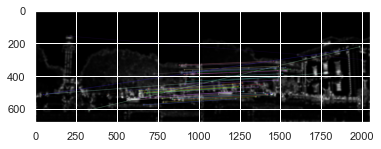

(<matplotlib.image.AxesImage at 0x1f4a3c33d90>, None)

In [16]:
#5 Select putative matches between 2 images
utt_left_8 = cv2.normalize(utt_left_harris, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
utt_right_8 = cv2.normalize(utt_right_harris, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(utt_left_8,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(utt_right_8,None)
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)
utt_img = cv2.drawMatches(utt_left_8, keypoints_1, utt_right_8, keypoints_2, matches[:50], utt_right_8, flags=2)
plt.imshow(utt_img), plt.show()

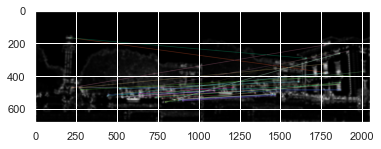

In [29]:
#6 Use RANSAC algorithm to estimate a homography mapping one image onto the other
##Homography Matching
orbot = cv2.ORB_create()
kp1, dsp1 = orbot.detectAndCompute(utt_left_8,None)
kp2, dsp2 = orbot.detectAndCompute(utt_right_8,None)
bf2 = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
match = bf2.match(dsp1,dsp2)
match = sorted(match, key = lambda x:x.distance)
imaj = cv2.drawMatches(utt_left_8, kp1, utt_right_8, kp2, match[:50], utt_right_8, flags=2)
plt.imshow(imaj)

In [34]:
##RANSAC Algorithm
def RANSAC(image_1_kp, image_2_kp, matches):
    image_1_points = np.zeros((len(matches), 1, 2), dtype=np.float32)
    image_2_points = np.zeros((len(matches), 1, 2), dtype=np.float32)

    for i in range(0,len(matches)):
        image_1_points[i] = image_1_kp[matches[i].queryIdx].pt
        image_2_points[i] = image_2_kp[matches[i].trainIdx].pt


    humography, mask = cv2.findHomography(image_1_points, image_2_points, cv2.RANSAC, ransacReprojThreshold=2.0)

    return humography

In [35]:
##RANSAC matching
RANSAC(kp1, kp2, match)

array([[ 7.85978328e+00,  1.90142037e+00, -4.68030643e+03],
       [ 4.90705203e-01,  1.25627354e+01, -3.29134897e+03],
       [ 5.58699780e-04,  1.15043289e-02,  1.00000000e+00]])

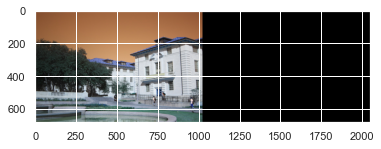

In [41]:
#7 Warping both images
unt_left = cv2.imread("uttower_left.JPG")
unt_right = cv2.imread("uttower_right.JPG")
left_img = cv2.cvtColor(unt_left,cv2.COLOR_BGR2GRAY)
right_img = cv2.cvtColor(unt_right,cv2.COLOR_BGR2GRAY)
suck = cv2.xfeatures2d.SIFT_create()
kp_1, dsp_1 = suck.detectAndCompute(left_img,None)
kp_2, dsp_2 = suck.detectAndCompute(right_img,None)
boyf = cv2.BFMatcher()
match_maker = boyf.knnMatch(dsp_1,dsp_2, k=2)
great = []
for m in match_maker:
    if (m[0].distance < 0.5*m[1].distance):
        great.append(m)
match_maker = np.asarray(great)
if (len(match_maker[:,0]) >= 4):
    src = np.float32([ kp_1[m.queryIdx].pt for m in match_maker[:,0] ]).reshape(-1,1,2)
    dst = np.float32([ kp_2[m.trainIdx].pt for m in match_maker[:,0] ]).reshape(-1,1,2)
    H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
else:
    raise AssertionError('Can’t find enough keypoints.')
dst = cv2.warpPerspective(unt_left,H,((unt_left.shape[1] + unt_right.shape[1]), unt_right.shape[0]))
dst[0:unt_right.shape[0], 0:unt_right.shape[1]] = unt_right
plt.imshow(dst)

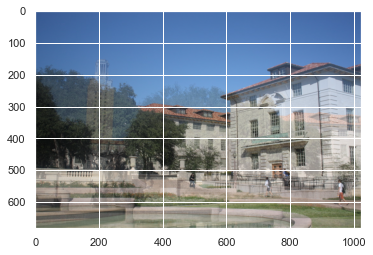

In [63]:
#8 Composite Both Images
rad_left = Image.open("uttower_left.JPG")
rad_right = Image.open("uttower_right.JPG")
rad_l_nm = np.asarray(rad_left)
rad_r_nm = np.asarray(rad_right)
Nice_Comp = cv2.addWeighted(rad_l_nm, 0.3, rad_r_nm, 0.7, 0.0)
plt.imshow(Nice_Comp)